# Setup

## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Installs

In [ ]:
!pip install sentence_transformers -q

     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 4.7 MB 47.7 MB/s 
     |████████████████████████████████| 1.3 MB 58.5 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 596 kB 75.6 MB/s 
     |████████████████████████████████| 6.6 MB 33.6 MB/s 


## Paths

In [ ]:
DATASET_FULL_TEXT = './gdrive/Shareddrives/DATASETS/PMC-Sents-FULL/'
MODEL = './gdrive/Shareddrives/MODELS/all-MiniLM-L6-v2_FullText_Span1_TripletAll-2022-08-16_17-23-14/model'

## Imports

In [ ]:
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 300
pd.options.mode.chained_assignment = 'raise'

import json

from tqdm import tqdm

import torch

# Load CSAbstruct Dataset

In [ ]:
df_train = pd.read_parquet(DATASET_FULL_TEXT + 'train_full_text_span1.parquet')
df_dev = pd.read_parquet(DATASET_FULL_TEXT + 'val_full_text_span1.parquet')
df_test = pd.read_parquet(DATASET_FULL_TEXT + 'test_full_text_span1.parquet')

df_test_triplet = pd.read_parquet(DATASET_FULL_TEXT + 'test_triplets_span1.parquet')
df_dev_triplets = pd.read_parquet(DATASET_FULL_TEXT + 'dev_triplets_span1.parquet')

In [ ]:
df_train.columns

Index(['id', 'text', 'label_id'], dtype='object')

In [ ]:
train_sentences = list(df_train['text'].values)
dev_sentences = list(df_dev['text'].values)
test_sentences = list(df_test['text'].values)

print(f'train_sentences: {len(train_sentences)}')
print(f'dev_sentences: {len(dev_sentences)}')
print(f'test_sentences: {len(test_sentences)}')

train_sentences: 138473
dev_sentences: 17309
test_sentences: 17310


In [ ]:
y_train_true = list(df_train['label_id'].values)
y_dev_true = list(df_dev['label_id'].values)
y_test_true = list(df_test['label_id'].values)

print(f'y_train_true: {len(y_train_true)}')
print(f'y_dev_true: {len(y_dev_true)}')
print(f'y_test_true: {len(y_test_true)}')

y_train_true: 138473
y_dev_true: 17309
y_test_true: 17310


# Fine Tuned Model

In [ ]:
from sentence_transformers import models, SentenceTransformer

tuned_model = SentenceTransformer(MODEL, device='cuda')

In [ ]:
from sentence_transformers import InputExample
from tqdm import tqdm

test_set = []

guid = 1
for idx, row in tqdm(df_test_triplet.iterrows(), total=len(df_test_triplet.index)):
    test_set.append(InputExample(
        guid=guid,
        texts=[row['anchor'], row['positive'], row['negative']],
    ))
    guid += 1
len(test_set)

100%|██████████| 17310/17310 [00:02<00:00, 7399.29it/s]


17310

In [ ]:
from sentence_transformers.evaluation import TripletEvaluator

print("Evaluating model on test set")
test_evaluator = TripletEvaluator.from_input_examples(
    test_set, write_csv=True, show_progress_bar=True, name='full_text-test'
)
tuned_model.evaluate(test_evaluator)

Evaluating model on test set


Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

0.7033506643558637

In [ ]:
dev_set = []

guid = 1
for idx, row in tqdm(df_dev_triplets.iterrows(), total=len(df_dev_triplets.index)):
    dev_set.append(InputExample(
        guid=guid,
        texts=[row['anchor'], row['positive'], row['negative']],
    ))
    guid += 1
len(dev_set)

100%|██████████| 17309/17309 [00:00<00:00, 17383.42it/s]


17309

In [ ]:
from sentence_transformers.evaluation import TripletEvaluator

dev_evaluator = TripletEvaluator.from_input_examples(
    dev_set, write_csv=True, show_progress_bar=True, name='full_text-dev'
)

In [ ]:
print("Evaluating model on dev set")
dev_evaluator(tuned_model)

Evaluating model on dev set


Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

0.7084175862268184

# Tests

## Generate Embeddings

In [ ]:
%time embeddings_gpu_train = tuned_model.encode(train_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_train = embeddings_gpu_train.cpu().numpy()
embeddings_cpu_train.shape

Batches:   0%|          | 0/4328 [00:00<?, ?it/s]

CPU times: user 58.9 s, sys: 995 ms, total: 59.9 s
Wall time: 52.8 s


(138473, 384)

In [ ]:
%time embeddings_gpu_dev = tuned_model.encode(dev_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_dev = embeddings_gpu_dev.cpu().numpy()
embeddings_cpu_dev.shape

Batches:   0%|          | 0/541 [00:00<?, ?it/s]

CPU times: user 7.46 s, sys: 128 ms, total: 7.58 s
Wall time: 6.63 s


(17309, 384)

In [ ]:
%time embeddings_gpu_test = tuned_model.encode(test_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_test = embeddings_gpu_test.cpu().numpy()
embeddings_cpu_test.shape

Batches:   0%|          | 0/541 [00:00<?, ?it/s]

CPU times: user 7.34 s, sys: 121 ms, total: 7.46 s
Wall time: 6.52 s


(17310, 384)

## Unsupervised

In [ ]:
from sklearn.cluster import KMeans

num_clusters = len(set(y_test_true))

kmeans_clusterer = KMeans(n_clusters=num_clusters)
%time kmeans_cluster_labels = kmeans_clusterer.fit_predict(embeddings_cpu_test)
len(kmeans_cluster_labels)

CPU times: user 2.44 s, sys: 1.47 s, total: 3.91 s
Wall time: 2.04 s


17310

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.metrics import mutual_info_score


print(f'Adjusted RI {adjusted_rand_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'RI {rand_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'Adjusted MI {adjusted_mutual_info_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'MI {mutual_info_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'Silhouette Score {silhouette_score(embeddings_cpu_test, kmeans_cluster_labels):.4f}')

Adjusted RI 0.3636
RI 0.6934
Adjusted MI 0.3017
MI 0.3371
Silhouette Score 0.9751


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


CPU times: user 3min 15s, sys: 2.96 s, total: 3min 18s
Wall time: 3min 10s


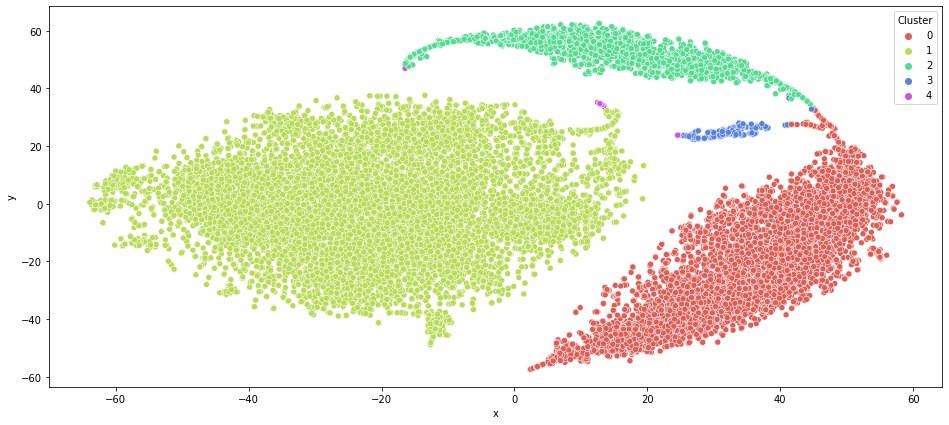

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tSNE=TSNE(n_components=2, init='pca')

%time tSNE_result=tSNE.fit_transform(embeddings_cpu_test)

df_kmeans = pd.DataFrame.from_dict({'x':tSNE_result[:,0],'y':tSNE_result[:,1],'Cluster':kmeans_cluster_labels})

plt.figure(figsize=(16,7))
ax = sns.scatterplot(x='x',y='y',hue='Cluster',palette=sns.color_palette("hls",num_clusters),data=df_kmeans,
               legend="full")

plt.show()

## Supervised

In [ ]:
import math

total = math.ceil(math.sqrt(len(train_sentences)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = [
    ('DecisionTreeClassifier', tree.DecisionTreeClassifier()),
    ('KNeighborsClassifier1', KNeighborsClassifier(n_neighbors=1, weights='distance')),
    ('KNeighborsClassifierSqrt', KNeighborsClassifier(n_neighbors=total, weights='distance')),
    ('KNeighborsClassifier5', KNeighborsClassifier(weights='distance')),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('MLPClassifier', MLPClassifier()),
]

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score
import time

output_results = []

for model in models:
  output_dict = {
      'model': model[0]
  }
  print(model[0])
  clf = model[1]
  start = time.time()
  clf = clf.fit(embeddings_cpu_train, y_train_true)
  end = time.time()
  y_pred = clf.predict(embeddings_cpu_test)
  
  output_dict['acc'] = accuracy_score(y_test_true, y_pred)
  output_dict['f1_macro'] = f1_score(y_test_true, y_pred, average='macro')
  output_dict['f1_micro'] = f1_score(y_test_true, y_pred, average='micro')  
  output_dict['f1_weighted'] = f1_score(y_test_true, y_pred, average='weighted')
  output_dict['time'] = end - start
  
  output_results.append(output_dict)
pd.DataFrame(output_results)

DecisionTreeClassifier
KNeighborsClassifier1
KNeighborsClassifierSqrt
KNeighborsClassifier5
RandomForestClassifier
MLPClassifier


,model,acc,f1_macro,f1_micro,f1_weighted,time
0,DecisionTreeClassifier,0.600924,0.456565,0.600924,0.605747,507.252246
1,KNeighborsClassifier1,0.650895,0.519893,0.650895,0.651402,0.059996
2,KNeighborsClassifierSqrt,0.714154,0.511169,0.714154,0.682666,0.060329
3,KNeighborsClassifier5,0.700982,0.549329,0.700982,0.687747,0.068298
4,RandomForestClassifier,0.715367,0.519741,0.715367,0.686525,1214.955227
5,MLPClassifier,0.713518,0.520098,0.713518,0.685860,1416.418469


In [ ]:
models = [
  ('SVM', SVC()),
]

In [ ]:
output_results = []

for model in models:
  output_dict = {
      'model': model[0]
  }
  print(model[0])
  clf = model[1]
  start = time.time()
  clf = clf.fit(embeddings_cpu_train, y_train_true)
  end = time.time()
  y_pred = clf.predict(embeddings_cpu_test)
  
  output_dict['acc'] = accuracy_score(y_test_true, y_pred)
  output_dict['f1_macro'] = f1_score(y_test_true, y_pred, average='macro')
  output_dict['f1_micro'] = f1_score(y_test_true, y_pred, average='micro')  
  output_dict['f1_weighted'] = f1_score(y_test_true, y_pred, average='weighted')
  output_dict['time'] = end - start
  
  output_results.append(output_dict)
pd.DataFrame(output_results)

SVM


,model,acc,f1_macro,f1_micro,f1_weighted,time
0,SVM,0.713692,0.509737,0.713692,0.682297,4469.940372
